In [42]:
import os
import torch
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils


import brian2cuda

from brian2 import prefs
from brian2 import set_device

os.chdir("/content")

set_device("cuda_standalone", build_on_run=False)

#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)




# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iinh - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iinh : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc2 : amp  # Synaptic input
I_tot = Iexc + Iexc2 + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
Iexc_post = w * X_pre : amp (summed)
'''

syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance
Iexc2_post = w * X_pre : amp (summed)
'''

syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance
Iinh_post = w * X_pre : amp (summed)
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups




def make_bottom_up_connections(R, E_0, E_1):
    S_p = Synapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect(condition='i == j')
    S_p.w = 'w_init'

    S_m = Synapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect(condition='i == j')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    S_p = Synapses(R, E_1, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect()
    S_p.w = 'rand() * w_init'

    S_m = Synapses(R, E_0, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect()
    S_m.w = 'rand() * w_init'

    return S_p, S_m

def make_gist_connections(Rs, G):
    S_gist_input = Synapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = Synapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output

def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/10

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    S_o = Synapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os, S_o

def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])
        connections[f"bottom_up_{i}"] = [S_p, S_m]

        if i != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i])
            connections[f"top_down_{i}"] = [S_p_td, S_m_td]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = Synapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]

    return Rs, Es_0, Es_1, G, Os, S_o_internal, connections

def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor

def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped

def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
dims = [2, 2, 2, 2]
num_classes_per_layer = 3
max_depth = 3

Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 5
N = 15
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 20
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)

# Network operation functions
@network_operation()
def add_inputs():
    # These references will be set before net.run(...) call
    pass

@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])

@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X

@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        print("n: ", n)
        # Retrieve top_down synapses
        td_key = f"top_down_{n}"
        if td_key in connections:
            S_p, S_m = connections[td_key]
            for i_idx in range(Rs[n+1].N):
                for j_idx in range(Es_0[n].N):
                    S_p.w[i_idx, j_idx] += lr * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens
                    S_m.w[i_idx, j_idx] += lr * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0

@network_operation()
def log_spikes():
    # Everything here runs on CPU
    # Get the new spikes from spike_mon
    # For example, we could retrieve the current length or the last spike index
    # Then write them to a file with Python I/O
    print("CHUNGUS IS BIG")
    new_spike_indices = spike_mon.i[:]
    new_spike_times   = spike_mon.t[:]
    # For demonstration, write them out
    with open("/content/outputs.txt", "a") as f:
        for i_spk, t_spk in zip(new_spike_indices, new_spike_times):
            f.write(f"{t_spk} {i_spk}\n")



# Extract all synapses and objects for the network
all_synapses = []
all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
all_synapses.append(external_syn)

monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(Rs[0])

s = 0
Os.run_regularly("dummy = store_spike(s)", dt = 10 * ms)


spike_mon = SpikeMonitor(Os)


net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,
    monitor, spike_monitor,
    add_inputs, debug, update_sums, apply_weight_update, log_spikes
)




all_batch_rates = []
output_spikes = []
for s, (stimulus_indexes, output_stimuli, input_stimuli) in enumerate(dl):
    print(f"batch n.{s}")

      # 1) Reset the spike count to 0 if you want each batch to be measured independently

    output_spikes.append(Os.spike_count)
    # 2) Set references for the network operations
    add_inputs.namespace['_stimulus_indexes'] = stimulus_indexes
    add_inputs.namespace['_output_stimuli'] = output_stimuli
    add_inputs.namespace['_input_stimuli'] = input_stimuli
    # Run the network
    # (batch_size + batch_size*num_pause_blocks)*100*ms

    run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
    net.run(run_time)
    #net.stop()

device.build(directory='cuda_project', compile=True, run=True)


WARNING    'i' is an internal variable of group 'synapses_401', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_402', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_405', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_406', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_409', but also exists in the run namespace with the value 2. The internal variable will be used. [

batch n.0
batch n.1
batch n.2
batch n.3
batch n.4
batch n.5
batch n.6


FileNotFoundError: Binary not found: `nvidia-smi`

In [34]:
net.stop()

In [37]:
spike_data = spike_mon.get_states()

NotImplementedError: Cannot retrieve the values of state variables in standalone code before the simulation has been run.

In [ ]:
output_spikes

In [ ]:
# Suppose you want to plot the last batch's firing rates
all_batch_rates = [spike_monitor_os.count/run_time for spike_monitor_os in output_monitors]

for batch_rates in all_batch_rates:

  plt.figure(figsize=(10, 5))
  plt.bar(range(Os.N), batch_rates)
  plt.xlabel("Os Neuron Index")
  plt.ylabel("Firing rate (Hz)")
  plt.title("Average firing rate of Os neurons (last batch)")
  plt.show()


NotImplementedError: Cannot retrieve the values of state variables in standalone code before the simulation has been run.

In [ ]:
from pprint import pprint

pprint(vars(spike_monitor))

{'_active': True,
 '_clock': Clock(dt=100. * usecond, name='defaultclock'),
 '_code_objects': [<weakproxy at 0x7d1fcfb813a0 to CUDAStandaloneCodeObject at 0x7d1fcfb34220>],
 '_contained_objects': [],
 '_creation_stack': "  File '/tmp/ipykernel_5550/3781894676.py', line 398, in "
                    '<module>\n'
                    '    spike_monitor = SpikeMonitor(Rs[0])',
 '_dependencies': {UUID('caf7ca2b-6f62-4194-9219-c53c3782bd4f')},
 '_full_creation_stack': '\n'
                         "  File '/usr/lib/python3.10/runpy.py', line 196, in "
                         '_run_module_as_main\n'
                         '    return _run_code(code, main_globals, None,\n'
                         "  File '/usr/lib/python3.10/runpy.py', line 86, in "
                         '_run_code\n'
                         '    exec(code, run_globals)\n'
                         '  File '
                         "'/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py', "
                    

NotImplementedError: Cannot retrieve the values of state variables in standalone code before the simulation has been run.

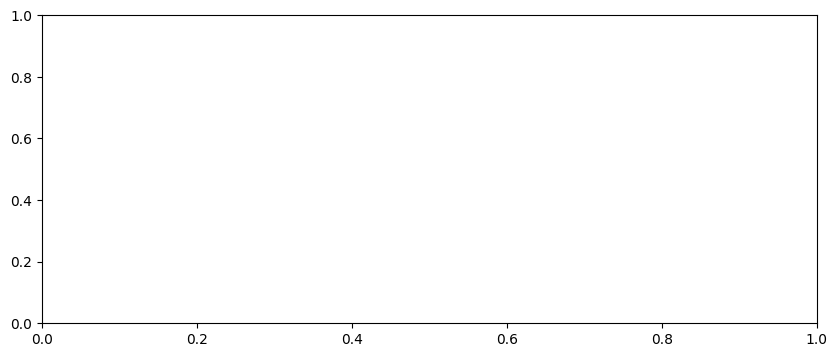

In [ ]:

# spike_monitor = SpikeMonitor(Os)


# Plot membrane potential

plt.figure(figsize=(10, 4))



# Firing rate plot
plt.subplot(1, 1, 1)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()




In [ ]:
def training_phase_1(network, dl):

  for label_input, curve_input in dl:
    ...

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Input')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Input')

plt.tight_layout()
plt.show()



## Other

In [ ]:
network = Network(
    *Rs,        # Unpack the list of NeuronGroups
    *Es_0,      # Unpack the list of NeuronGroups
    *Es_1,      # Unpack the list of NeuronGroups
    G,          # Single NeuronGroup is fine
    Os,         # Single NeuronGroup is fine
    connections["output_internal"],   # Single Synapses object is fine
    connections["gist_input"],        # Single Synapses object is fine
    *connections["gist_output"],      # Unpack the list of Synapses
    *connections["output_external"],  # Unpack the list of Synapses
    spike_monitor,
    monitor,
    debug,
    update_sums,
    apply_weight_update
)


In [ ]:
eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  : amp
'''


neuron = make_groups([1], eqs = eqs_neuron)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c] for c in np.ones(1)*0.8]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(neuron)

run(1 * second)

# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''

In [ ]:
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y_post = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Input current
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = input_stimuli(t)  : amp
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Synaptic input (summed)
I_tot = I + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

syn_eqs_inh= '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation

In [ ]:
# Update logic
@network_operation(dt = batch_size * msec_step * ms)
def update_sums( ):

    current_idx = int(defaultclock.t / msec_step*ms)

    if stimulus_indexes.values[current_idx] == 1:


        for n in range(len(Rs)-1):

            for i in range(len(Rs[n])):

                '''
                Rs[n].batch_sum_X[i] += Rs[n].X_[i]

                Es_0[n].batch_sum_X[i] += Es_0[n].X_[i]

                Es_1[n].batch_sum_X[i] += Es_1[n].X_[i]
                '''

                Rs[n].batch_sum_X += Rs[n].X_
                Es_0[n].batch_sum_X += Es_0[n].X_
                Es_1[n].batch_sum_X += Es_1[n].X_


@network_operation( dt = batch_size * msec_step * ms )
def apply_weight_update():

    print("Applying weight update")

    for n in range(len(Rs)-1):
        print("n: ", n)

        for i in range(len(Rs[n])):
            print("i: ", i)
            for j in range(len(Es_0[n])):
                print("j: ", j)


                S_p, S_m = connections[f"top_down_{n}"]

                S_p.w[i,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n].batch_sum_X[i] * siemens

                S_m.w[i,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n].batch_sum_X[i]  * siemens

                Rs[n].batch_sum_X[i] = 0

                Es_0[n].batch_sum_X[i]= 0

                Es_1[n].batch_sum_X[i] = 0



for stimulus_indexes, output_stimuli, input_stimuli in dl:

    print("indexes", stimulus_indexes.values.shape, stimulus_indexes.values)

    run((batch_size + batch_size*num_pause_blocks) * 100 * ms)